# FAST HI观测规划助手`obshelper`示例2：无转角的OTF扫描观测

by astroR2 2025/5/10

* 示例2将介绍如何使用本程序包规划常见模式的扫描观测，适用于无多波束转角的`OTF`模式。

* 天顶角与合适的观测时间的检查请见另一个例子。

* 注意：本程序与FAST官方无关，纯个人开发使用，请仔细检查输出结果，如有错误概不负责。请务必先详细阅读[FAST观测常见问题](https://fast.bao.ac.cn/cms/article/147/)与[用户帮助文档](https://fast.bao.ac.cn/cms/article/80/)。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import hiviewer as hv
import os

from obshelper.opt_source import OptSource
from obshelper.utils.util import line_set

from astropy.coordinates import SkyCoord
from astropy import units as u

## 3C286的OTF观测

这里只是举个例子，但确实是我们常用的定标源观测模式。

#### Object ####
Previous Transit time: 2025-05-09 23:14:09.000
Next Transit time: 2025-05-10 23:10:14.000
#### Sun ####
Next Rise time: 2025-05-11 06:09:09.000
Previous Set time: 2025-05-10 19:28:30.000
input time at night?: True


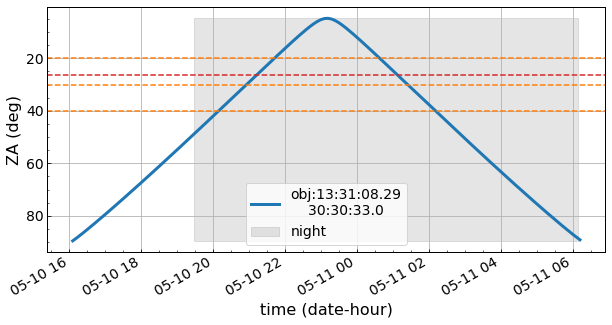

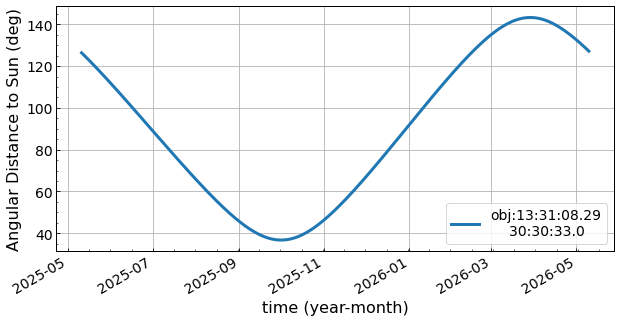

In [2]:
# 这里我们直接输入坐标，无需速度
ra, dec = 202.784533, 30.509155
self = OptSource('3C286', ra, dec, vel = None)

# 检查在这天的ZA变化，尽量在ZA<26.4度内观测
BJ_time = '2025-05-10 21:00:00'
self.plot_ZA(BJ_time)

# 一年中距离太阳的角距离变化
self.plot_Sun_AngleDist(BJ_time)

观测参数含义见第一个例子. **注意这里multibeamOTF=False**，换源时间会比MultibeamOTF短

In [3]:
from obshelper.MultiBeamOTF_Time import MultiOTFcalculator
otc = MultiOTFcalculator(ra, dec, diff_ra= 65, diff_dec = 4 * 4.97)
otc.get_startend()
# 4.97角分是无转角的每一行波束间隔
otc.input_OTF_para(direction = '-', scan_gap = 4.97, scan_speed = 15, multibeamOTF=False)
otc.calculate_time()

MultiBeam OTF, direction:  -
Scan gap: 4.97 arcmin
Scan speed: 15.0 arcsec / s
Scan 5.0 times along -, switch 4.0 times.
Need total 1372.0 s = 22.866666666666667 min.


下面我们直接画出采样点的分布。采样时间0.2s，**注意这里的旋转角是0度**，可以使得每一个波束都穿过3C286.

Sample time: 0.2 s
Rotation angle: 0.0 deg


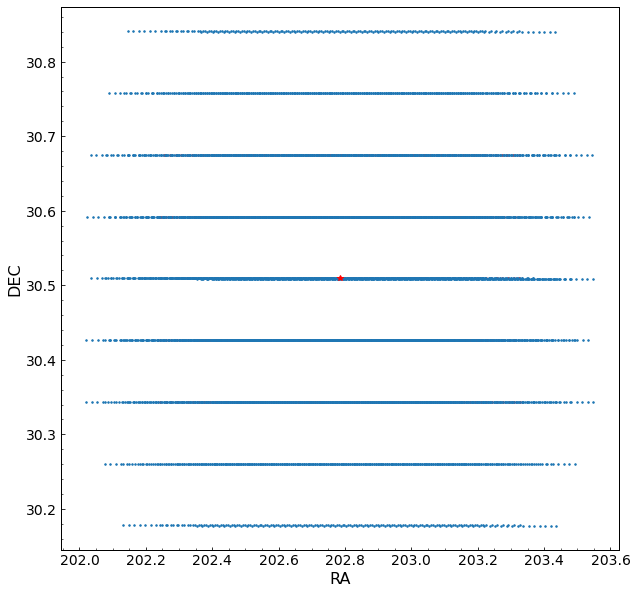

In [4]:
fig, ax = plt.subplots(figsize = (10, 10))
otc.footprints_M01(sample_time = 0.2, rotate_angle=0)
otc.footprints_all()
        
gap = 20
for i in np.arange(0, 19, 1):
    
    c = 'r' if i == 0 else f'C0'
    px, py = otc.ra_all[i][::gap], otc.dec_all[i][::gap]
    ax.plot(px, py, '.', c = c, ms = 3, alpha = 1)

ax.set_xlabel('ra')    
ax.set_ylabel('dec') 

ax.plot(self.ra, self.dec, 'r*')
line_set(ax, xlabel = 'RA', ylabel = 'DEC', legend=False, 
            )

plt.show()

In [5]:
otc.tot_time.to(u.min)

<Quantity 22.86666667 min>

In [6]:
# 生成FAST要求的txt格式，也可以复制粘贴手动提交

header = ["#Source Name", "Observation Mode", "RA(hh:mm:ss.ss)", "DEC(dd:mm:ss.s)", "StartRA(hh:mm:ss.ss)", "StartDEC(dd:mm:ss.s)", "EndRA(hh:mm:ss.ss) ", "EndDEC(dd:mm:ss.s)",
         "time(sec)"]

df = pd.DataFrame(columns=header)
def format_radec(pos):
    ra1 = pos.ra.to_string(unit = u.hourangle, sep = ':', precision=2, pad = True)
    dec1 = pos.dec.to_string(unit = u.degree, sep = ':', precision=1, alwayssign = True)
    return ra1, dec1


i = 0
ra_, dec_ = format_radec(otc.center)
ra_start, dec_start = format_radec(otc.start)
ra_end, dec_end = format_radec(otc.end)
t = otc.tot_time.to(u.second).value
df.loc[i] = [f"3C286", "OnTheFlyMapping", ra_, dec_, ra_start, dec_start, ra_end, dec_end, t]

In [7]:
df

,#Source Name,Observation Mode,RA(hh:mm:ss.ss),DEC(dd:mm:ss.s),StartRA(hh:mm:ss.ss),StartDEC(dd:mm:ss.s),EndRA(hh:mm:ss.ss),EndDEC(dd:mm:ss.s),time(sec)
0,3C286,OnTheFlyMapping,13:31:08.29,+30:30:33.0,13:28:58.29,+30:20:36.6,13:33:18.29,+30:40:29.4,1372.0


In [8]:
# 保存时不需要最后一列时间列
df[df.keys()[:-1]].to_csv('./obsfile/3C286_MultibeamOTF.txt', sep='|', index = False)